In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
import tensorflow as tf
import ast
import librosa

In [16]:
train_csv = pd.read_csv('training_data.csv')
test_csv = pd.read_csv('test_data.csv')

labels = train_csv['instrument'].unique()
#spelling error in the test_data we need to account for
label_encoder = {'Sound_Guiatr' : 0}
for index, label in enumerate(labels):
    label_encoder[label] = index

print(labels)
train_csv['instrument'].value_counts()

['Sound_Guitar' 'Sound_Drum' 'Sound_Violin' 'Sound_Piano']


instrument
Sound_Piano     33310
Sound_Guitar    19158
Sound_Drum      19022
Sound_Violin    19022
Name: count, dtype: int64

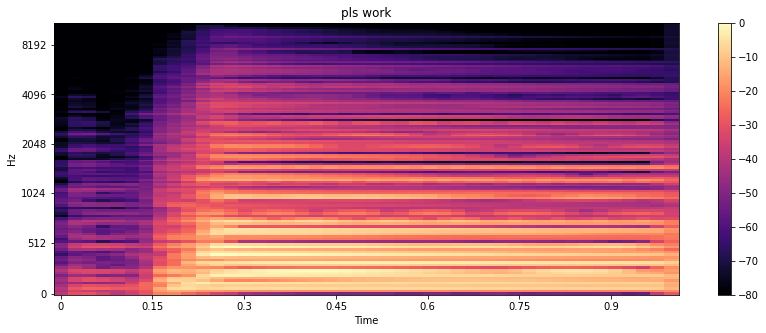

In [25]:
#testing our data has survived
train_csv.head()
flat_mel_spec = np.loadtxt(f'./train_mel_spec/00.txt')
mel_spec = flat_mel_spec.reshape(128,44)
plt.figure(figsize=(14,5))

librosa.display.specshow(mel_spec, sr=22050, x_axis='time', y_axis='mel')
plt.title('pls work')
plt.colorbar()

In [27]:
#preparing training data

guitar_df = train_csv[train_csv['instrument'] == 'Sound_Guitar']
piano_df = train_csv[train_csv['instrument'] == 'Sound_Drum']
drum_df = train_csv[train_csv['instrument'] == 'Sound_Violin']
violin_df = train_csv[train_csv['instrument'] == 'Sound_Piano']

#750 examples from each for intail training
data_combind_train_validation = guitar_df['mel spec ref'].tolist()[:750]
labels_combind_train_validation = guitar_df['instrument'].tolist()[:750]

data_combind_train_validation.extend(piano_df['mel spec ref'].tolist()[:750])
labels_combind_train_validation.extend(piano_df['instrument'].tolist()[:750])

data_combind_train_validation.extend(drum_df['mel spec ref'].tolist()[:750])
labels_combind_train_validation.extend(drum_df['instrument'].tolist()[:750])

data_combind_train_validation.extend(violin_df['mel spec ref'].tolist()[:750])
labels_combind_train_validation.extend(violin_df['instrument'].tolist()[:750])


#mel spec data and reshape it
for index, data in enumerate(data_combind_train_validation): 
    data_combind_train_validation[index] = np.loadtxt(f'./train_mel_spec/{data}').reshape((128, 44))
 
#change labels to 0-4   
for index, data in enumerate(labels_combind_train_validation):
    labels_combind_train_validation[index] = label_encoder[data]
    

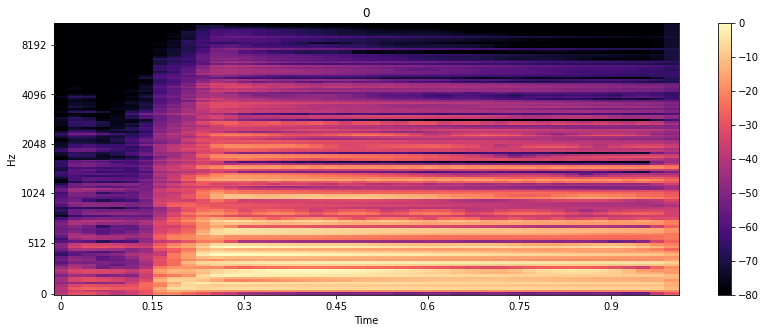

In [28]:
#testing the conversion has worked
plt.figure(figsize=(14,5))
librosa.display.specshow(data_combind_train_validation[0], sr=22050, x_axis='time', y_axis='mel')
plt.title(labels_combind_train_validation[0])
plt.colorbar()

In [30]:
test_csv['instrument'].value_counts()

instrument
Sound_Guiatr    1536
Sound_Piano     1076
Sound_Drum       843
Sound_Violin     276
Name: count, dtype: int64

In [31]:
#spelling mistake in test data - should be guitar not guiatr
guitar_df = test_csv[test_csv['instrument'] == 'Sound_Guiatr']
piano_df = test_csv[test_csv['instrument'] == 'Sound_Drum']
drum_df = test_csv[test_csv['instrument'] == 'Sound_Violin']
violin_df = test_csv[test_csv['instrument'] == 'Sound_Piano']

data_test = guitar_df['mel spec ref'].tolist()
labels_test = guitar_df['instrument'].tolist()

data_test.extend(piano_df['mel spec ref'].tolist())
labels_test.extend(piano_df['instrument'].tolist())

data_test.extend(drum_df['mel spec ref'].tolist())
labels_test.extend(drum_df['instrument'].tolist())

data_test.extend(violin_df['mel spec ref'].tolist())
labels_test.extend(violin_df['instrument'].tolist())

#mel spec data and reshape it
for index, data in enumerate(data_test): 
    data_test[index] = np.loadtxt(f'./test_mel_spec/{data}').reshape((128, 44))
 
#change labels to 0-4   
for index, data in enumerate(labels_test):
    labels_test[index] = label_encoder[data]
    

In [36]:
#model set up

input_shape=(128,44,1)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 42, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 21, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 63, 21, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 19, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 9, 64)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 30, 9, 64)        

In [58]:
#history reporter
def report(history,y_pred,y_true):
    plt.plot(history.epoch, history.history["accuracy"],history.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Training (blue) and validation (orange) History')
    plt.show()
    
    predicted= np.argmax(y_pred,axis=1)
    actual = np.argmax(y_true,axis=1)
    print(f'Test Accuracy {(predicted==actual).sum() *100/len(actual)}%')
    cm=ConfusionMatrixDisplay.from_predictions(actual, predicted)#,display_labels=train_csv['instrument'].unique()) 

In [52]:


x_train,x_val,y_train,y_val= train_test_split(data_combind_train_validation, labels_combind_train_validation,
                                                test_size=0.125,
                                                shuffle=True,
                                                stratify=labels_combind_train_validation)


In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(np.array(x_train), np.array(y_train),
                    epochs=10, validation_data=(np.array(x_val), np.array(y_val)))

Epoch 1/10


/home/michael/.local/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 [==============================] - 18s 196ms/step - loss: 1.2676 - accuracy: 0.3726 - val_loss: 1.1429 - val_accuracy: 0.5067
Epoch 2/10
83/83 [==============================] - 15s 181ms/step - loss: 0.9567 - accuracy: 0.5337 - val_loss: 0.8319 - val_accuracy: 0.6107
Epoch 3/10
83/83 [==============================] - 14s 167ms/step - loss: 0.7195 - accuracy: 0.6099 - val_loss: 0.7207 - val_accuracy: 0.6347
Epoch 4/10
83/83 [==============================] - 14s 168ms/step - loss: 0.6083 - accuracy: 0.6686 - val_loss: 0.5859 - val_accuracy: 0.6773
Epoch 5/10
83/83 [==============================] - 14s 168ms/step - loss: 0.5019 - accuracy: 0.7128 - val_loss: 0.5982 - val_accuracy: 0.7067
Epoch 6/10
83/83 [==============================] - 14s 166ms/step - loss: 0.4671 - accuracy: 0.7238 - val_loss: 0.4151 - val_accuracy: 0.7173
Epoch 7/10
83/83 [==============================] - 14s 163ms/step - loss: 0.4282 - accuracy: 0.7272 - val_loss: 0.4347 - val_accuracy: 0.7200
Epoch 8/10

117/117 [==============================] - 5s 45ms/step


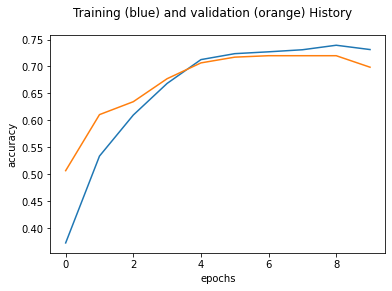

AxisError: axis 1 is out of bounds for array of dimension 1

In [59]:
y_pred = model.predict(np.array(data_test))
report(history, y_pred, labels_test)